In [1]:
import wandb
import logging
from argparse import Namespace
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import gc

In [2]:
import net_config as cfg
%run models.ipynb
%run trainer.ipynb

In [3]:
%env "WANDB_NOTEBOOK_NAME" "NN"
wandb.login()

env: "WANDB_NOTEBOOK_NAME"="NN"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matus13579 (mteam0). Use `wandb login --relogin` to force relogin


True

In [9]:
class Lizard_dataset(Dataset):
    def __init__(self, path_images, path_labels):
        self.images = []
        self.labels = []
        self.transform = T.ToPILImage()

        self.class_colors = torch.FloatTensor([
            [0, 0, 0]           #black
            , [30, 144, 255]    #dodger blue
            , [220, 20, 60]     #crimson
            , [34, 139, 34]     #forest green
            , [238, 130, 238]   #violet
            , [255, 255, 0]     #yellow
            , [211, 211, 211]   #gainsboro
            ]
        )

        # Load images and labels as tensors to cpu (moved to gpu during training)
        self.images = torch.load(path_images, map_location="cpu").type(torch.float32)
        self.labels = torch.load(path_labels, map_location="cpu").type(torch.float32)

        #print(self.images.dtype)
        #print(self.labels.dtype)

        img_count = self.images.size(dim=0)
        num_channels = self.images.size(dim=1)
        height = self.images.size(dim=2)
        width = self.images.size(dim=3)

        img_count2 = self.labels.size(dim=0)
        height2 = self.labels.size(dim=1)
        width2 = self.labels.size(dim=2)

        if ( img_count != img_count2 or 
            height != height2 or 
            width != width2 or
            num_channels != 3
            ):

            print("Wrong tensor shapes!")
            print (f"- Images tensor shape : '{self.labels.shape}'")
            print (f"- Labels tensor shape : '{self.labels.shape}'")
        
    def __len__(self):
        return self.images.size(dim=0)

    def __getitem__(self, idx):
        image = self.images[idx, :, :, :]
        label = self.labels[idx, :, :]

        #image = torch.unsqueeze(image, dim= 0)
        #label = torch.unsqueeze(label, dim= 0)

        return (image, label)
    
    def show_imgLabel(self, idx):
        img_t, label_t = self.__getitem__(idx)

        # Show image
        image = self.transform(img_t)

        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f'Original Image  with index = {idx}')
        plt.axis('off')
        plt.show()

        # show segmentation
        converted_tensor = torch.nn.functional.embedding(label_t.type(torch.int32), self.class_colors).permute(2, 0, 1)
        colormap = self.transform(converted_tensor)

        # show segmentation
        plt.figure(figsize=(8, 8))
        plt.imshow(colormap)
        plt.title('Segmentation Heatmap')
        plt.axis('off')
        plt.show()

    def show_tensorImg(self, t):
        t = torch.squeeze(t)
        img = self.transform(t)
        plt.show(img)
        

In [5]:
class wanDB_run: 
    def __init__(self, run_name, run_id,  model: nn.Module, config: Namespace):

        wandb.login()
        assert wandb.run is None, "wanDB has another run currently active"
        
        self.run = wandb.init(
        entity = "matus13579", 
        project = "NN-z2",     
        name = run_name, 
        id = run_id
        )

        wandb.config = cfg.config_to_dict(config)

        self.trainer = Trainer(model, config)

        self.bestModel = None
        self.bestAccuracy = None

        self.datasets_loaded = False
        self.current_epoch = 0


    def load_datasets(self, train_pathX, train_pathY, val_pathX, val_pathY, test_pathX, test_pathY):
        trainData = Lizard_dataset(train_pathX, train_pathY)
        valData = Lizard_dataset(val_pathX, val_pathY)
        testData = Lizard_dataset(test_pathX, test_pathY)

        trainData.show_imgLabel(5)

        self.trainer.load_dataset(trainData, valData, testData)
        self.datasets_loaded = True
    
    def load_model(model_path):
        pass

    def save_model(self):
        if (self.bestModel is not None):
            pass

    def get_best_model(self):
        return self.bestModel
    
    def execute_training(self, epoch_count):
        assert self.datasets_loaded, "Datasets are NOT loaded"

        for _ in range(epoch_count):
            self.current_epoch += 1
            print(f"--Starting epoch {self.current_epoch}--")

            # Train model
            self.trainer.train_model()

            # Get metrics
            tl = self.trainer.stats.metric_average(self.trainer.metric_name_Tloss)
            vl = self.trainer.stats.metric_average(self.trainer.metric_name_Vloss)
            acc = self.trainer.stats.metric_average(self.trainer.metric_name_acc)
            iou = self.trainer.stats.metric_average(self.trainer.metric_name_IoU)
            dice = self.trainer.stats.metric_average(self.trainer.metric_name_dice)

            # Save metrics to wandb
            self.run.log({"loss_train": tl, "epoch": self.current_epoch})
            self.run.log({"loss_val": vl, "epoch": self.current_epoch})
            self.run.log({"accuracy": acc, "epoch": self.current_epoch})
            self.run.log({"iou": iou, "epoch": self.current_epoch})
            self.run.log({"dice": dice, "epoch": self.current_epoch})
            
            # Get best model
            if (self.best_accuracy is None) or (self.best_accuracy < acc):
                best_accuracy = acc
                best_model = self.trainer.model

            print(f"--Ending epoch {self.current_epoch}--")
    
    def stop_run(self):
        self.run.finish()

        del self.trainer
        self.datasets_loaded = False
        gc.collect()


In [6]:
net = U_Net(3, 6, cfg.config_to_dict(cfg.config_Unet))

myrun = wanDB_run("test", "2", net, cfg.config_Unet)


wandb: Currently logged in as: matus13579. Use `wandb login --relogin` to force relogin


Using cpu device for training


torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


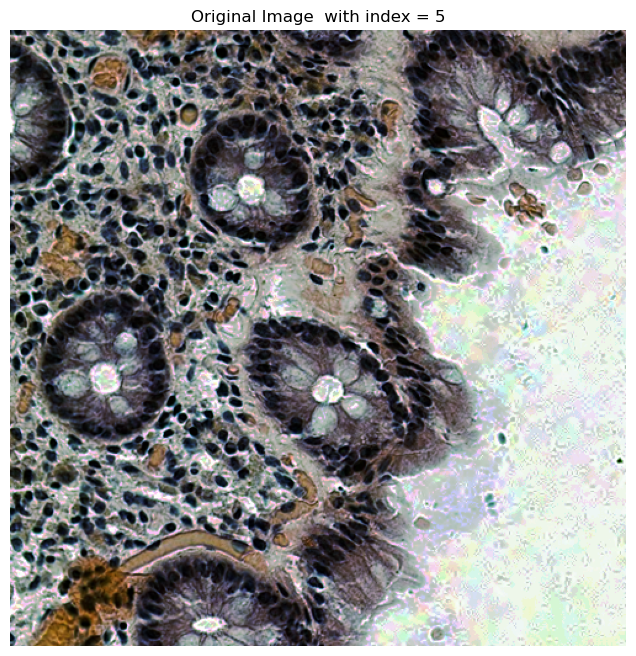

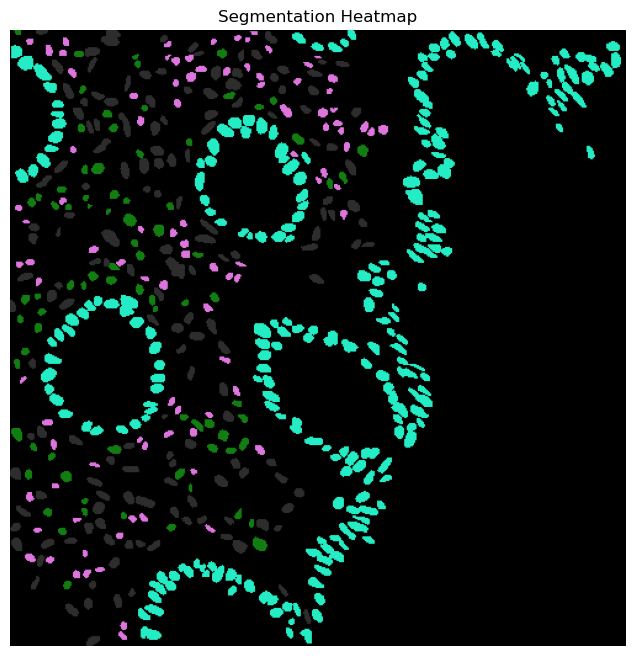

In [10]:
data_dir = "./data_norm/"

myrun.load_datasets(
    data_dir + "X_train.pt"
    , data_dir + "y_train.pt" 
    , data_dir + "X_val.pt"
    , data_dir + "y_val.pt"
    , data_dir + "X_test.pt"
    , data_dir + "y_test.pt"
)


In [11]:
myrun.execute_training(5)

--Starting epoch 1--
This U-Net skips connections using concatenation!
torch.Size([64, 128, 125, 125])
torch.Size([64, 128, 125, 125])


KeyboardInterrupt: 

In [32]:
#myrun.stop_run()
wandb.finish()